# BC Grid Extrapolation

Testing errors generated by grid extrapolation for extremely cool spot bolometric corrections. A first test of this will be to use a more extensive Phoenix color grid to explore effects that may be missing from MARCS (aka: condensates).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import LinearNDInterpolator

### Setting up Phoenix Grid Interpolation

First, load required color tables (1 optical, 1 NIR).

In [3]:
phx_col_dir = '/Users/grefe950/Projects/starspot/starspot/color/tab/phx/CIFIST15'
opt_table = np.genfromtxt('{0}/colmag.BT-Settl.server.COUSINS.Vega'.format(phx_col_dir), comments='!')
nir_table = np.genfromtxt('{0}/colmag.BT-Settl.server.2MASS.Vega'.format(phx_col_dir), comments='!')

Generate (linear) interpolation surfaces as a function of $\log g$ and $T_{\rm eff}$.

In [5]:
opt_surface = LinearNDInterpolator(opt_table[:, :2], opt_table[:, 4:8])
nir_surface = LinearNDInterpolator(nir_table[:, :2], nir_table[:, 4:7])

### BT-Settl Colorize a Dartmouth Isochrone

Load a standard isochrone, with MARCS colors.

In [6]:
iso = np.genfromtxt('data/dmestar_00120.0myr_z+0.00_a+0.00_marcs.iso')

Compute colors using Phoenix BT-Settl models using CIFIST 2015 color tables. Colors were shown to be compatible with MARCS colors [in another note](http://nbviewer.ipython.org/github/gfeiden/Notebook/blob/master/Daily/20150902_phoenix_cifist_bcs.ipynb).

In [7]:
phx_opt_mags = opt_surface(10.0**iso[:, 1], iso[:, 2])
phx_nir_mags = nir_surface(10.0**iso[:, 1], iso[:, 2])

Convert from surface magnitudes to absolute magnitudes.

In [8]:
for i in range(phx_opt_mags.shape[1]):
    phx_opt_mags[:, i] = phx_opt_mags[:, i] - 5.0*np.log10(10**iso[:, 4]*6.956e10/3.086e18) + 5.0

for i in range(phx_nir_mags.shape[1]):
    phx_nir_mags[:, i] = phx_nir_mags[:, i] - 5.0*np.log10(10**iso[:, 4]*6.956e10/3.086e18) + 5.0

Stack colors with stellar properties to form a new isochrone.

In [9]:
phx_iso = np.column_stack((iso[:, :6], phx_opt_mags))  # stack props with BVRI
phx_iso = np.column_stack((phx_iso, phx_nir_mags))     # stack props/BVRI with JHK

### Load Spotted Isochrone(s)

There are two types of spotted isochrones, one with magnitudes and colors with average surface properties, the other has more detailed information about spot temperatures and luminosities.

In [29]:
orig_iso  = np.genfromtxt('/Users/grefe950/Projects/starspot/models/age_120.0+z_0.00/isochrone_120.0myr_z+0.00_a+0.00_marcs.iso')
spot_mags = np.genfromtxt('/Users/grefe950/Projects/starspot/models/age_120.0+z_0.00/sts/mag_zet+0.70_eps+1.00_rho+0.40_pi+0.70.dat')
spot_prop = np.genfromtxt('/Users/grefe950/Projects/starspot/models/age_120.0+z_0.00/sts/spots_zet+0.70_eps+1.00_rho+0.40_pi+0.70.dat')

Compute colors for photospheric and spot components.

In [12]:
phx_opt_phot = opt_surface(10**spot_prop[:, 1], spot_mags[:, 2])
phx_opt_spot = opt_surface(10**spot_prop[:, 2], spot_mags[:, 2])
phx_nir_phot = nir_surface(10**spot_prop[:, 1], spot_mags[:, 2])
phx_nir_spot = nir_surface(10**spot_prop[:, 2], spot_mags[:, 2])

Convert surface magnitudes to absolute magnitudes.

In [13]:
for i in range(phx_opt_phot.shape[1]):
    phx_opt_phot[:, i] = phx_opt_phot[:, i] - 5.0*np.log10(10**spot_mags[:, 4]*6.956e10/3.086e18) + 5.0
    phx_opt_spot[:, i] = phx_opt_spot[:, i] - 5.0*np.log10(10**spot_mags[:, 4]*6.956e10/3.086e18) + 5.0

for i in range(phx_nir_phot.shape[1]):
    phx_nir_phot[:, i] = phx_nir_phot[:, i] - 5.0*np.log10(10**spot_mags[:, 4]*6.956e10/3.086e18) + 5.0
    phx_nir_spot[:, i] = phx_nir_spot[:, i] - 5.0*np.log10(10**spot_mags[:, 4]*6.956e10/3.086e18) + 5.0

Compute luminosity fractions for spots and photosphere for use in combining the two contributions.

In [30]:
L_spot = 10**spot_prop[:, 4]/10**orig_iso[:, 3]
L_phot = 10**spot_prop[:, 3]/10**orig_iso[:, 3]

Now combine spot properties with the photospheric properties to derive properties for spotted stars.

In [35]:
phx_opt_spot_mags = np.empty(phx_opt_phot.shape)
phx_nir_spot_mags = np.empty(phx_nir_phot.shape)

for i in range(phx_opt_phot.shape[1]):
    phx_opt_spot_mags[:,i] = -2.5*np.log10(0.6*10**(-phx_opt_phot[:,i]/2.5) 
                                         + 0.4*10**(-phx_opt_spot[:,i]/2.5))

for i in range(phx_nir_phot.shape[1]):
    phx_nir_spot_mags[:,i] = -2.5*np.log10(0.6*10**(-phx_nir_phot[:,i]/2.5) 
                                         + 0.4*10**(-phx_nir_spot[:,i]/2.5))

Stack with average surface properties to form a spotted isochrone.

In [36]:
spt_iso = np.column_stack((spot_mags[:, :6], phx_opt_spot_mags))
spt_iso = np.column_stack((spt_iso, phx_nir_spot_mags))

### Isochrone Comparisons

We may now compare morphologies of spotted isochrones computed using Phoenix and MARCS color tables.

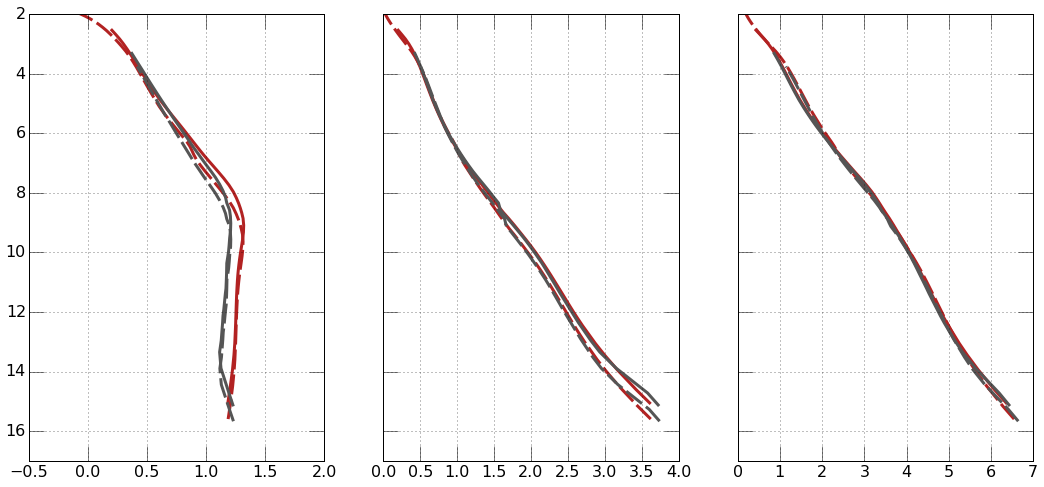

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(18., 8.), sharey=True)

for axis in ax:
    axis.grid(True)
    axis.set_ylim(17., 2.)
    axis.tick_params(which='major', axis='both', labelsize=16., length=15.)

# V/(B-V)
ax[0].set_xlim(-0.5, 2.0)
ax[0].plot(iso[:, 6] - iso[:, 7], iso[:, 7], lw=3, c='#b22222')
ax[0].plot(spot_mags[:, 7] - spot_mags[:, 8], spot_mags[:, 8], dashes=(20., 5.), lw=3, c='#b22222')
ax[0].plot(phx_iso[:, 6] - phx_iso[:, 7], phx_iso[:, 7], lw=3, c='#555555')
ax[0].plot(spt_iso[:, 6] - spt_iso[:, 7], spt_iso[:, 7], dashes=(20., 5.), lw=3, c='#555555')

# V/(V-Ic)
ax[1].set_xlim(0.0, 4.0)
ax[1].plot(iso[:, 7] - iso[:, 8], iso[:, 7], lw=3, c='#b22222')
ax[1].plot(spot_mags[:, 8] - spot_mags[:,10], spot_mags[:, 8], dashes=(20., 5.), lw=3, c='#b22222')
ax[1].plot(phx_iso[:, 7] - phx_iso[:, 9], phx_iso[:, 7], lw=3, c='#555555')
ax[1].plot(spt_iso[:, 7] - spt_iso[:, 9], spt_iso[:, 7], dashes=(20., 5.), lw=3, c='#555555')

# V/(V-K)
ax[2].set_xlim(0.0, 7.0)
ax[2].plot(iso[:, 7] - iso[:,10], iso[:, 7], lw=3, c='#b22222')
ax[2].plot(spot_mags[:, 8] - spot_mags[:,13], spot_mags[:, 8], dashes=(20., 5.), lw=3, c='#b22222')
ax[2].plot(phx_iso[:, 7] - phx_iso[:,12], phx_iso[:, 7], lw=3, c='#555555')
ax[2].plot(spt_iso[:, 7] - spt_iso[:,12], spt_iso[:, 7], dashes=(20., 5.), lw=3, c='#555555')

Optical CMDs appear to be in good order, even though some of the spot properties may extend beyond the formal MARCS grid. Now we may check NIR CMDs.

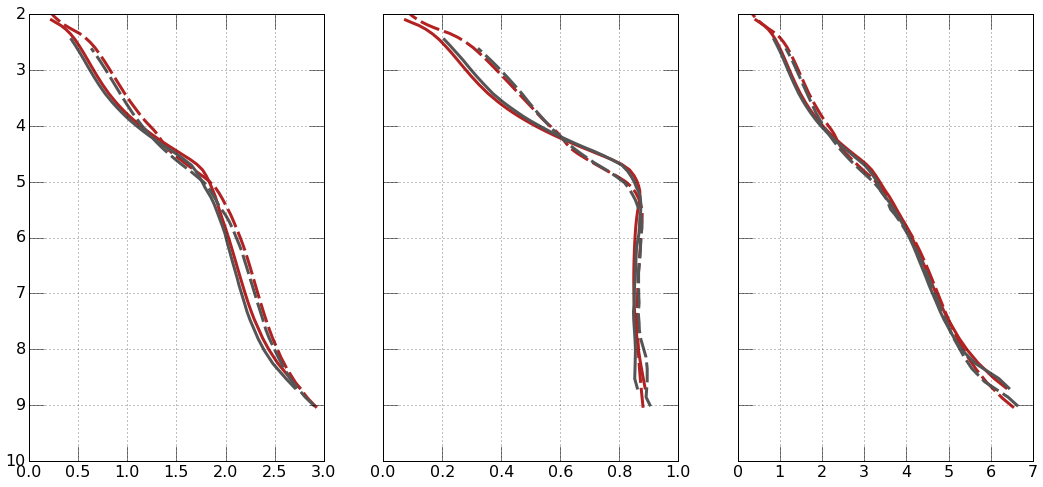

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(18., 8.), sharey=True)

for axis in ax:
    axis.grid(True)
    axis.set_ylim(10., 2.)
    axis.tick_params(which='major', axis='both', labelsize=16., length=15.)

# K/(Ic-K)
ax[0].set_xlim(0.0, 3.0)
ax[0].plot(iso[:, 8] - iso[:, 10], iso[:, 10], lw=3, c='#b22222')
ax[0].plot(spot_mags[:, 10] - spot_mags[:, 13], spot_mags[:, 13], dashes=(20., 5.), lw=3, c='#b22222')
ax[0].plot(phx_iso[:, 9] - phx_iso[:, 12], phx_iso[:, 12], lw=3, c='#555555')
ax[0].plot(spt_iso[:, 9] - spt_iso[:, 12], spt_iso[:, 12], dashes=(20., 5.), lw=3, c='#555555')

# K/(J-K)
ax[1].set_xlim(0.0, 1.0)
ax[1].plot(iso[:, 9] - iso[:, 10], iso[:, 10], lw=3, c='#b22222')
ax[1].plot(spot_mags[:, 11] - spot_mags[:,13], spot_mags[:, 13], dashes=(20., 5.), lw=3, c='#b22222')
ax[1].plot(phx_iso[:, 10] - phx_iso[:, 12], phx_iso[:, 12], lw=3, c='#555555')
ax[1].plot(spt_iso[:, 10] - spt_iso[:, 12], spt_iso[:, 12], dashes=(20., 5.), lw=3, c='#555555')

# K/(V-K)
ax[2].set_xlim(0.0, 7.0)
ax[2].plot(iso[:, 7] - iso[:,10], iso[:, 10], lw=3, c='#b22222')
ax[2].plot(spot_mags[:, 8] - spot_mags[:,13], spot_mags[:, 13], dashes=(20., 5.), lw=3, c='#b22222')
ax[2].plot(phx_iso[:, 7] - phx_iso[:,12], phx_iso[:, 12], lw=3, c='#555555')
ax[2].plot(spt_iso[:, 7] - spt_iso[:,12], spt_iso[:, 12], dashes=(20., 5.), lw=3, c='#555555')